In [131]:
using Plots
using LinearAlgebra
pyplot()

Plots.PyPlotBackend()

In [136]:
η(x) = exp(-20*(x-2)^2) + exp(-(x-5)^2)

function adv_center(h,k,xf,tf)
    
    m = Int(ceil(xf/h))
    n = Int(ceil(tf/k))
    r = k/h
    
    A = Tridiagonal(0.5*r*ones(m-1), ones(m), -0.5*r*ones(m-1))
    
    x = LinRange(0,xf,m)
    t = zeros(n)
    t[1] = k
    
    U = zeros(m,n)
    U[:,1] = η.(x) 
    for i=2:n
        U[:,i] = A*U[:,i-1] 
        t[i] = i*k
    end
    
    return m,n,x,t,U
end

function adv_upwind(h,k,xf,tf)
    
    m = Int(ceil(xf/h))
    n = Int(ceil(tf/k))
    r = k/h
    
    A = Tridiagonal(r*ones(m-1), (1-r)*ones(m), zeros(m-1))
    
    x = LinRange(0,xf,m)
    t = zeros(n)
    t[1] = k
    
    U = zeros(m,n)
    U[:,1] = η.(x) 
    for i=2:n
        U[:,i] = A*U[:,i-1] 
        t[i] = i*k
    end
    
    return m,n,x,t,U
end

function adv_lax(h,k,xf,tf)
    
    m = Int(ceil(xf/h))
    n = Int(ceil(tf/k))
    r = k/h
    
    A = Tridiagonal((0.5+0.5*r)*ones(m-1), zeros(m), (0.5-0.5*r)*ones(m-1))
    
    x = LinRange(0,xf,m)
    t = zeros(n)
    t[1] = k
    
    U = zeros(m,n)
    U[:,1] = η.(x) 
    for i=2:n
        U[:,i] = A*U[:,i-1] 
        t[i] = i*k
    end
    
    return m,n,x,t,U
end

function adv_frog(h,k,xf,tf)
    
    m = Int(ceil(xf/h))
    n = Int(ceil(tf/k))
    r = k/h
    
    A = Tridiagonal(r*ones(m-1), zeros(m), -r*ones(m-1))
    
    x = LinRange(0,xf,m)
    t = zeros(n)
    t[1] = k
    
    U = zeros(m,n)
    U[:,1] = η.(x) 
    A_lax = Tridiagonal((0.5+r)*ones(m-1), zeros(m), (0.5-r)*ones(m-1))
    U[:,2] = A_lax*U[:,1]
    
    for i=3:n
        U[:,i] = A*U[:,i-1] + U[:,i-2]
        t[i] = i*k
    end
    
    return m,n,x,t,U
end

function adv_wendroff(h,k,xf,tf)
    
    m = Int(ceil(xf/h))
    n = Int(ceil(tf/k))
    r = k/h
    
    A = Tridiagonal(0.5*(r^2+r)*ones(m-1), (1-r^2)*ones(m), 0.5*(r^2-r)*ones(m-1))
    
    x = LinRange(0,xf,m)
    t = zeros(n)
    t[1] = k
    t[2] = 2*k
    U = zeros(m,n)
    U[:,1] = η.(x) 
    for i=2:n
        U[:,i] = A*U[:,i-1] 
        t[i] = i*k
    end
    
    return m,n,x,t,U
end

function plot_solutions(h,k,xf,tf)
    begin
        m,n,x,t,U = adv_center(h,0.8*k,xf,tf)
        plt_cen = plot(title = "Esquema Central")
        plot!(plt_cen, x, U[:,end], label="approx")
        plot!(plt_cen, x, η.(x .- tf), label="η(x-tf)")
    end

    begin
        m,n,x,t,U = adv_upwind(h,0.8*k,xf,tf)
        plt_up = plot(legend=:topleft, title="Upwind")
        plot!(plt_up, x, U[:,end], label="approx")
        plot!(plt_up, x, η.(x .- tf), label="η(x-tf)")
    end

    begin
        m,n,x,t,U = adv_lax(h,0.8*k,xf,tf)
        plt_lax = plot(legend=:topleft, title = "Lax-Friedrichs")
        plot!(plt_lax, x, U[:,end], label="approx")
        plot!(plt_lax, x, η.(x .- tf), label="η(x-tf)")
    end

    begin
        m,n,x,t,U = adv_frog(h,0.8*k,xf,tf)
        plt_frog = plot(title="Leapfrog", legend=:topleft)
        plot!(plt_frog, x, U[:,end], label="approx")
        plot!(plt_frog, x, η.(x .- tf), label="η(x-tf)")
    end

    begin
        m,n,x,t,U = adv_wendroff(h,0.8*k,xf,tf)
        plt_wen = plot(legend=:topleft, title="Lax-Wendroff")
        plot!(plt_wen, x, U[:,end], label="approx")
        plot!(plt_wen, x, η.(x .- tf), label="η(x-tf)")
    end
    
    return plot(plt_cen, plt_up, plt_lax, plt_frog, plt_wen, fmt=:png,yticks=optimize_ticks())
end

plot_solutions (generic function with 2 methods)

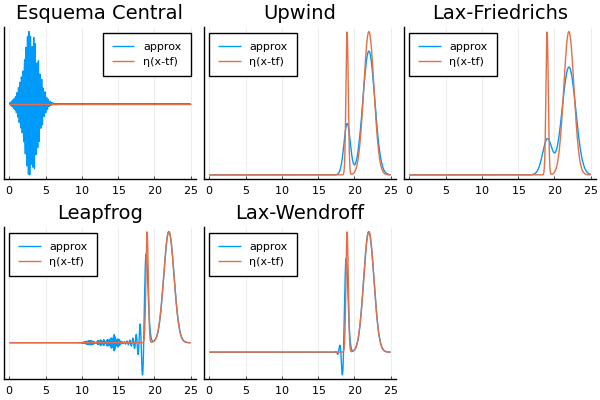

In [137]:
plot_solutions(0.05,0.05,25,17)

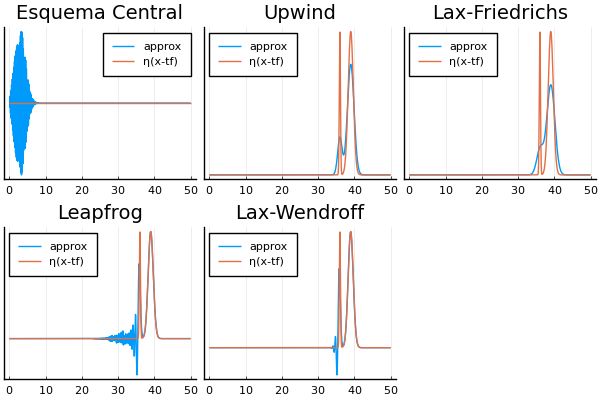

In [138]:
plot_solutions(0.05,0.05,50,34)

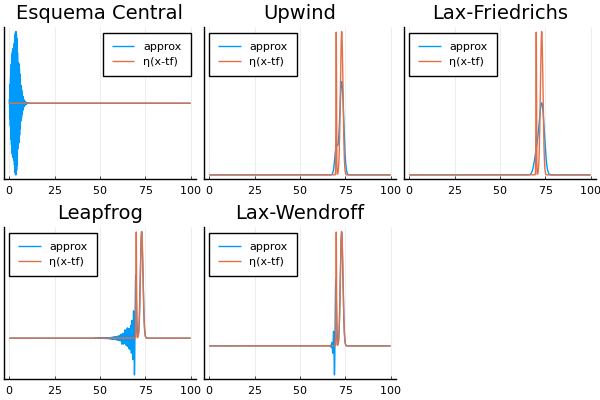

In [139]:
plot_solutions(0.05,0.05,100,68)

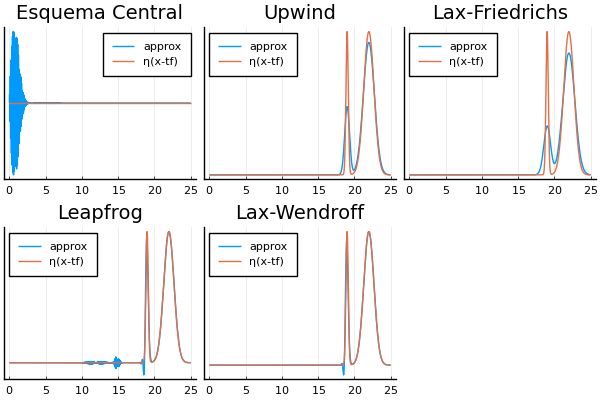

In [140]:
plot_solutions(0.05/2, 0.05/2, 17)

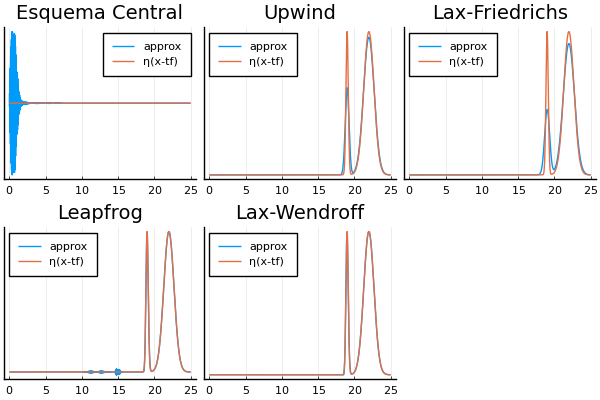

In [141]:
plot_solutions(0.05/4, 0.05/4, 17)

In [50]:
function get_Error(f::Function)
    
    h = [0.1/2^i for i=1:5]
    k = 0.8*h
    error_h = zeros(5)
    error_k = zeros(5)
    
    for i=1:5
        m,n,x,t,U = f(h[i],k[i],17)
        error_h[i] = sqrt(h[i])*norm(U[:,end] - η.(x .- 17))
        error_k[i] = sqrt(k[i])*norm(U[Int(length(x)/2), :] - [η(x[Int(length(x)/2)]-i) for i in t])
    end
    
    return h, error_h, k, error_k
end

get_Error (generic function with 1 method)

In [147]:
function plot_Error(f::Function)

    h, error_h, k, error_k = get_Error(f) 

    plot_error_h = plot(xaxis =:log, yaxis =:log, legend=:bottomright)
    plot_error_k = plot(xaxis =:log, yaxis =:log, legend=:bottomright)
    
    plot!(plot_error_h, h, error_h, label=false)
    plot!(plot_error_k, k, error_k, label=false)
    
    if f in [adv_lax, adv_upwind]
        plot!(plot_error_h, h, h, line=:dash, label="h")
        plot!(plot_error_k, k, k, line=:dash, label="k")
    end
    if f in [adv_wendroff, adv_frog, adv_center]
        plot!(plot_error_h, h, h.*h, line=:dash, label="h²")
        plot!(plot_error_k, k, k.*k, line=:dash, label="k²")
    end
    title = Dict([adv_center, adv_upwind, adv_lax, adv_frog, adv_wendroff].=>["Esquema Central", "Upwind", "Lax-Friedrichs", "Leapfrog", "Lax-Wendroff"])
    plot(plot_error_h, plot_error_k, title = title[f])
end

plot_Error (generic function with 1 method)

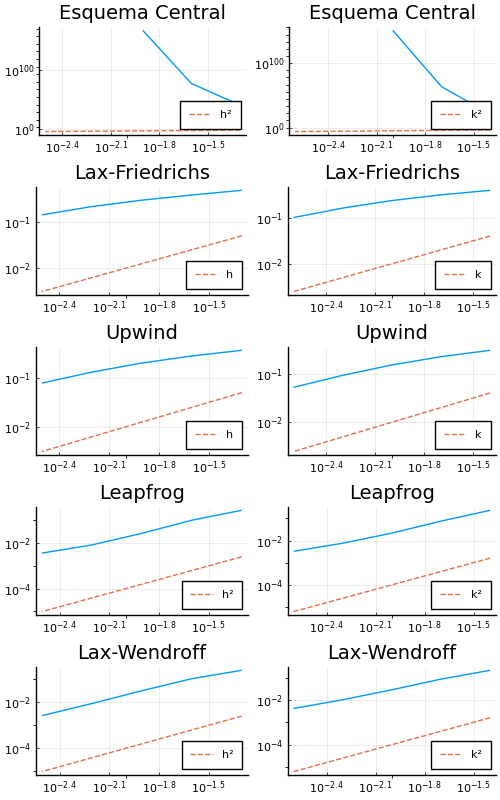

In [149]:
fig0 = plot_Error(adv_center)
fig1 = plot_Error(adv_lax)
fig2 = plot_Error(adv_upwind)
fig3 = plot_Error(adv_frog)
fig4 = plot_Error(adv_wendroff)

plot(fig0, fig1, fig2, fig3, fig4, layout = (5,1), size=(500,800))